In [1]:
import pandas as pd

from helpers.data_helper import load_data, load_data_robust, load_true_labels, add_labels_to_dataset, split_data

In [2]:
# PATHS 

# 1. santos | intranet_server | apache2 | intranet.smith.santos.com.access.log 
path_santos = "../AIT_LD-v2/santos"
path_log_file = "/gather/intranet_server/logs/auth.log"
path_true_labels = "/labels/intranet_server/logs/auth.log"

In [3]:
df_raw = load_data(path_santos + path_log_file)

# Extract timestamp
df_raw['timestamp'] = df_raw[0].str.extract(r'(\w{3}\s\d{2}\s\d{2}:\d{2}:\d{2})')
df_raw = df_raw[["timestamp", 0]]
df_raw.columns = ["timestamp", "message"]

# Remove timestamp from message
df_raw["message"] = df_raw["message"].str.replace(r'(\w{3}\s\d{2}\s\d{2}:\d{2}:\d{2})', '', regex=True)

df_raw

,timestamp,message
0,Jan 16 06:25:14,intranet-server CRON[14139]: pam_unix(cron:se...
1,Jan 16 06:39:01,intranet-server CRON[14285]: pam_unix(cron:se...
2,Jan 16 06:39:01,intranet-server CRON[14285]: pam_unix(cron:se...
3,Jan 16 06:47:01,intranet-server CRON[14361]: pam_unix(cron:se...
4,Jan 16 06:47:03,intranet-server CRON[14361]: pam_unix(cron:se...
...,...,...
265,Jan 17 23:09:01,intranet-server CRON[22741]: pam_unix(cron:se...
266,Jan 17 23:17:01,intranet-server CRON[22810]: pam_unix(cron:se...
267,Jan 17 23:17:01,intranet-server CRON[22810]: pam_unix(cron:se...
268,Jan 17 23:39:01,intranet-server CRON[22816]: pam_unix(cron:se...


In [4]:
df_raw.describe()

,timestamp,message
count,270,270
unique,137,268
top,Jan 17 11:58:17,intranet-server sudo: pam_unix(sudo:session):...
freq,5,2


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  270 non-null    object
 1   message    270 non-null    object
dtypes: object(2)
memory usage: 4.3+ KB


In [6]:
df_raw.isnull().sum()

timestamp    0
message      0
dtype: int64

In [7]:
df_raw.duplicated().sum()

0

In [8]:
# Check duplicates

df_raw[df_raw.duplicated()]

,timestamp,message


In [9]:
df_true_labels = load_true_labels(path_santos + path_true_labels)

df_true_labels.head(10)

,line,labels,rules
0,185,"[attacker_change_user, escalate]",{'attacker_change_user': ['attacker.escalate.s...
1,186,"[attacker_change_user, escalate, escalated_com...",{'attacker_change_user': ['attacker.escalate.s...
2,187,"[attacker_change_user, escalate]",{'attacker_change_user': ['attacker.escalate.s...
3,188,"[attacker_change_user, escalate]",{'attacker_change_user': ['attacker.escalate.s...
4,189,"[attacker_change_user, escalate]",{'attacker_change_user': ['attacker.escalate.s...
5,190,"[escalated_command, escalated_sudo_command, es...",{'escalated_command': ['attacker.escalate.sudo...
6,191,"[escalated_command, escalated_sudo_command, es...",{'escalated_command': ['attacker.escalate.sudo...
7,192,"[escalated_command, escalated_sudo_command, es...",{'escalated_command': ['attacker.escalate.sudo...
8,193,"[escalated_command, escalated_sudo_command, es...",{'escalated_command': ['attacker.escalate.sudo...
9,194,"[escalated_command, escalated_sudo_command, es...",{'escalated_command': ['attacker.escalate.sudo...


In [10]:
# Extract features

# Possible features:
# - process (sudo, su, sshd, cron)
# - user (root, www-data. ?MORE?) -> Decided not to use
# - sensitive commands 
# - session open / close
# - suspicious patterns (user switch, new session)
# - text based features (e.g. using TF-IDF vectorization (or other technique))


In [11]:
# Information this file contributes to the report:
# Compromised user account (and time of gaining root access)
# Which files were accessed
# Which commands were executed
# Present Working Directory (PWD) 

In [12]:
from helpers.intranet_auth_log_helper import extract_features

df_features = extract_features(df_raw)

df_features

,prcs_sudo,prcs_su,prcs_sshd,prcs_cron,dir_root,dir_shadow,dir_passwd,sess_open,sess_close,sess_new,user_switch
0,False,False,False,True,False,False,False,False,True,False,False
1,False,False,False,True,False,False,False,True,False,False,False
2,False,False,False,True,False,False,False,False,True,False,False
3,False,False,False,True,False,False,False,True,False,False,False
4,False,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
265,False,False,False,True,False,False,False,False,True,False,False
266,False,False,False,True,False,False,False,True,False,False,False
267,False,False,False,True,False,False,False,False,True,False,False
268,False,False,False,True,False,False,False,True,False,False,False


In [13]:
df_combined = pd.concat([df_raw, df_features], axis=1)

df_combined.head(10)

,timestamp,message,prcs_sudo,prcs_su,prcs_sshd,prcs_cron,dir_root,dir_shadow,dir_passwd,sess_open,sess_close,sess_new,user_switch
0,Jan 16 06:25:14,intranet-server CRON[14139]: pam_unix(cron:se...,False,False,False,True,False,False,False,False,True,False,False
1,Jan 16 06:39:01,intranet-server CRON[14285]: pam_unix(cron:se...,False,False,False,True,False,False,False,True,False,False,False
2,Jan 16 06:39:01,intranet-server CRON[14285]: pam_unix(cron:se...,False,False,False,True,False,False,False,False,True,False,False
3,Jan 16 06:47:01,intranet-server CRON[14361]: pam_unix(cron:se...,False,False,False,True,False,False,False,True,False,False,False
4,Jan 16 06:47:03,intranet-server CRON[14361]: pam_unix(cron:se...,False,False,False,True,False,False,False,False,True,False,False
5,Jan 16 07:09:01,intranet-server CRON[14492]: pam_unix(cron:se...,False,False,False,True,False,False,False,True,False,False,False
6,Jan 16 07:09:01,intranet-server CRON[14492]: pam_unix(cron:se...,False,False,False,True,False,False,False,False,True,False,False
7,Jan 16 07:17:01,intranet-server CRON[14567]: pam_unix(cron:se...,False,False,False,True,False,False,False,True,False,False,False
8,Jan 16 07:17:01,intranet-server CRON[14567]: pam_unix(cron:se...,False,False,False,True,False,False,False,False,True,False,False
9,Jan 16 07:39:01,intranet-server CRON[14572]: pam_unix(cron:se...,False,False,False,True,False,False,False,True,False,False,False


In [14]:
# Add true labels

df_combined = add_labels_to_dataset(df_combined, df_true_labels)

df_combined.iloc[183:197]

,timestamp,message,prcs_sudo,prcs_su,prcs_sshd,prcs_cron,dir_root,dir_shadow,dir_passwd,sess_open,sess_close,sess_new,user_switch,labels,true_type
183,Jan 17 11:39:01,intranet-server CRON[20653]: pam_unix(cron:se...,False,False,False,True,False,False,False,False,True,False,False,NaN,0
184,Jan 17 11:58:17,intranet-server su[20749]: Successful su for ...,False,True,False,False,False,False,False,False,False,False,False,"['attacker_change_user', 'escalate']",1
185,Jan 17 11:58:17,intranet-server su[20749]: + /dev/pts/1 www-d...,False,True,False,False,False,False,False,False,False,False,False,"['attacker_change_user', 'escalate', 'escalate...",1
186,Jan 17 11:58:17,intranet-server su[20749]: pam_unix(su:sessio...,False,True,False,False,False,False,False,True,False,False,False,"['attacker_change_user', 'escalate']",1
187,Jan 17 11:58:17,intranet-server systemd-logind[987]: New sess...,False,False,False,False,False,False,False,False,False,True,False,"['attacker_change_user', 'escalate']",1
188,Jan 17 11:58:17,intranet-server systemd: pam_unix(systemd-use...,False,False,False,False,False,False,False,True,False,False,False,"['attacker_change_user', 'escalate']",1
189,Jan 17 11:58:27,intranet-server sudo: gmorgan : TTY=pts/1 ; ...,True,True,False,False,False,False,False,False,False,False,False,"['escalated_command', 'escalated_sudo_command'...",1
190,Jan 17 11:58:29,intranet-server sudo: gmorgan : TTY=pts/1 ; ...,True,True,False,False,False,True,False,False,False,False,False,"['escalated_command', 'escalated_sudo_command'...",1
191,Jan 17 11:58:29,intranet-server sudo: pam_unix(sudo:session):...,True,True,False,False,False,False,False,True,False,False,False,"['escalated_command', 'escalated_sudo_command'...",1
192,Jan 17 11:58:29,intranet-server sudo: pam_unix(sudo:session):...,True,True,False,False,False,False,False,False,True,False,False,"['escalated_command', 'escalated_sudo_command'...",1


In [15]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

def select_best_features(df_features, labels, k=10):
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    selected_features = selector.fit_transform(df_features, labels)
    selected_columns = df_features.columns[selector.get_support()].tolist()

    scores = pd.DataFrame({
        "feature": df_features.columns,
        "score": selector.scores_
    }).sort_values(by="score", ascending=False)

    print("Feature importance scores:")
    print(scores)

    return df_features[selected_columns]

In [16]:
feature_selection = select_best_features(df_features, df_combined["true_type"], k="all")

feature_selection

Feature importance scores:
        feature     score
3     prcs_cron  0.173507
1       prcs_su  0.140687
0     prcs_sudo  0.090747
7     sess_open  0.020930
2     prcs_sshd  0.016835
8    sess_close  0.016386
6    dir_passwd  0.005888
10  user_switch  0.004842
4      dir_root  0.000000
5    dir_shadow  0.000000
9      sess_new  0.000000


,prcs_sudo,prcs_su,prcs_sshd,prcs_cron,dir_root,dir_shadow,dir_passwd,sess_open,sess_close,sess_new,user_switch
0,False,False,False,True,False,False,False,False,True,False,False
1,False,False,False,True,False,False,False,True,False,False,False
2,False,False,False,True,False,False,False,False,True,False,False
3,False,False,False,True,False,False,False,True,False,False,False
4,False,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
265,False,False,False,True,False,False,False,False,True,False,False
266,False,False,False,True,False,False,False,True,False,False,False
267,False,False,False,True,False,False,False,False,True,False,False
268,False,False,False,True,False,False,False,True,False,False,False


In [17]:
import numpy as np

def check_feature_correlations(df_features, threshold=0.85):
    corr_matrix = df_features.corr().abs()
    high_corr = np.where(np.triu(corr_matrix, 1) > threshold)
    return list(zip(corr_matrix.index[high_corr[0]], 
                   corr_matrix.columns[high_corr[1]], 
                   corr_matrix.values[high_corr]))

In [18]:
feature_correlation = check_feature_correlations(feature_selection, threshold=0.85)

feature_correlation

[('prcs_su', 'prcs_cron', 0.8719833883657405),
 ('sess_open', 'sess_close', 0.9494578075118609)]

In [19]:
# TODO: Improve using feature selection and correlation results

In [20]:
# Remove Nan from labels
df_combined["labels"] = df_combined["labels"].fillna("")

In [21]:
x_train, x_test, x_val, y_train, y_test, y_val = split_data(feature_selection, df_combined["true_type"])

Training set size:  189  Test set size:  54  Validation set size:  27

Class distribution in training set:
9

Class distribution in validation set:
1

Class distribution in test set:
2


In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = {
    'intr_auth_randomforest': RandomForestClassifier(n_estimators=100, random_state=42),
    'intr_auth_gradientboost': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'intr_auth_svc': SVC(kernel='rbf', random_state=42),
    'intr_auth_mlp': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def train_and_evaluate():
    results = {}
    for name, model in models.items():
        model.fit(x_train, y_train)
        print(f"Model: {name}")
        print(f"Training score: {model.score(x_train, y_train)}")
        print(f"Validation score: {model.score(x_val, y_val)}")
        print(f"Test score: {model.score(x_test, y_test)}")

        val_pred = model.predict(x_val)

        results[name] = {
                'accuracy': accuracy_score(y_val, val_pred),
                'precision': precision_score(y_val, val_pred, average='weighted'),
                'recall': recall_score(y_val, val_pred, average='weighted'),
                'f1': f1_score(y_val, val_pred, average='weighted'),
                'conf_matrix': confusion_matrix(y_val, val_pred)
            }
        print("-----------------------")

    print(results)

    return results

results = train_and_evaluate()

Model: intr_auth_randomforest
Training score: 1.0
Validation score: 1.0
Test score: 1.0
-----------------------
Model: intr_auth_gradientboost
Training score: 1.0
Validation score: 1.0
Test score: 1.0
-----------------------
Model: intr_auth_svc
Training score: 1.0
Validation score: 1.0
Test score: 1.0
-----------------------
Model: intr_auth_mlp
Training score: 1.0
Validation score: 1.0
Test score: 1.0
-----------------------
{'intr_auth_randomforest': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'conf_matrix': array([[26,  0],
       [ 0,  1]], dtype=int64)}, 'intr_auth_gradientboost': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'conf_matrix': array([[26,  0],
       [ 0,  1]], dtype=int64)}, 'intr_auth_svc': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'conf_matrix': array([[26,  0],
       [ 0,  1]], dtype=int64)}, 'intr_auth_mlp': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'conf_matrix': array([[26,  0],
      

In [ ]:
# Save models to disk
from helpers.intranet_auth_log_helper import save_models_to_disk

save_models_to_disk(models, "./trained-models/intranet_auth_log") # Pass overwrite = True to overwrite

Model intr_auth_randomforest already exists at ./trained-models/intranet_auth_log\intr_auth_randomforest.joblib. Skipping...
Model intr_auth_gradientboost already exists at ./trained-models/intranet_auth_log\intr_auth_gradientboost.joblib. Skipping...
Model intr_auth_svc already exists at ./trained-models/intranet_auth_log\intr_auth_svc.joblib. Skipping...
Model intr_auth_mlp already exists at ./trained-models/intranet_auth_log\intr_auth_mlp.joblib. Skipping...


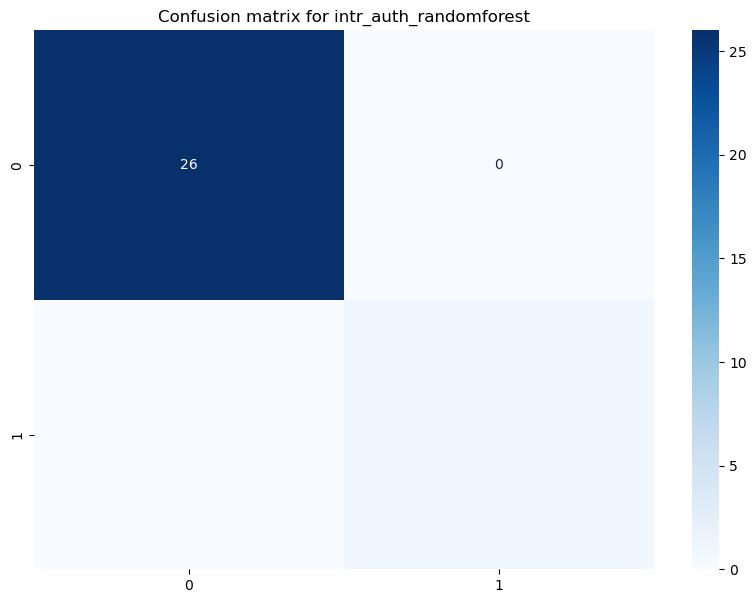

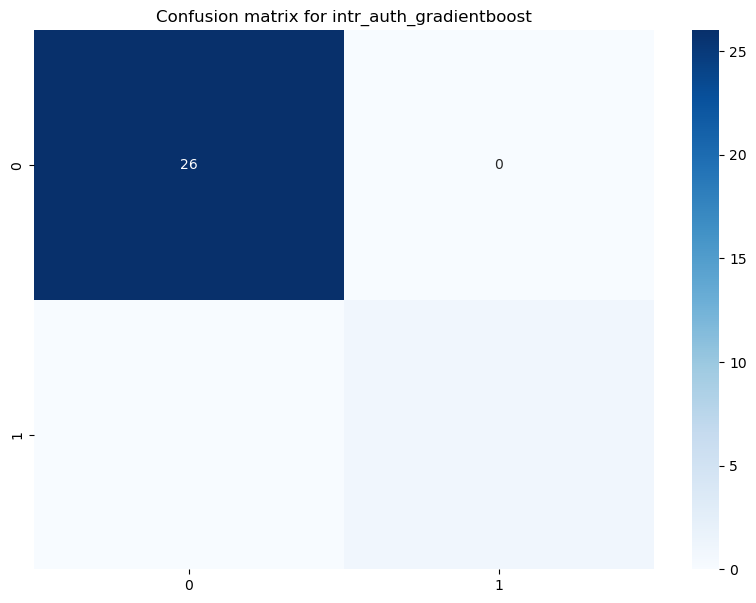

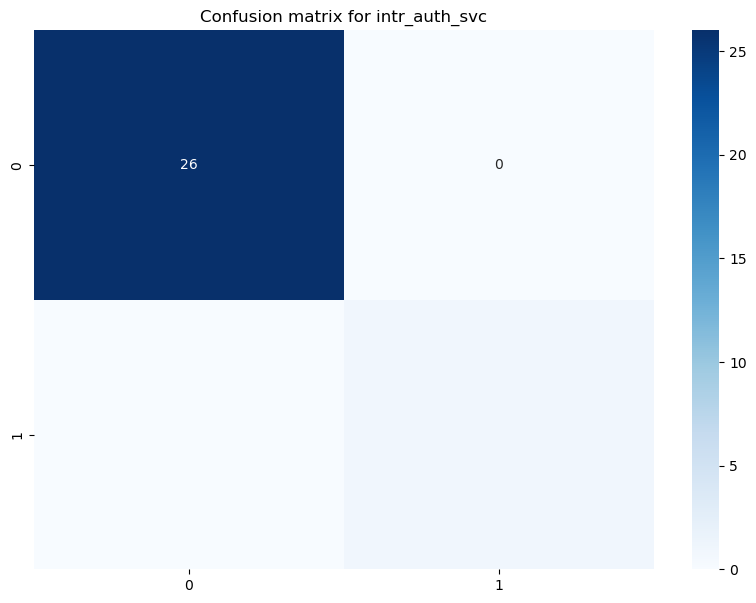

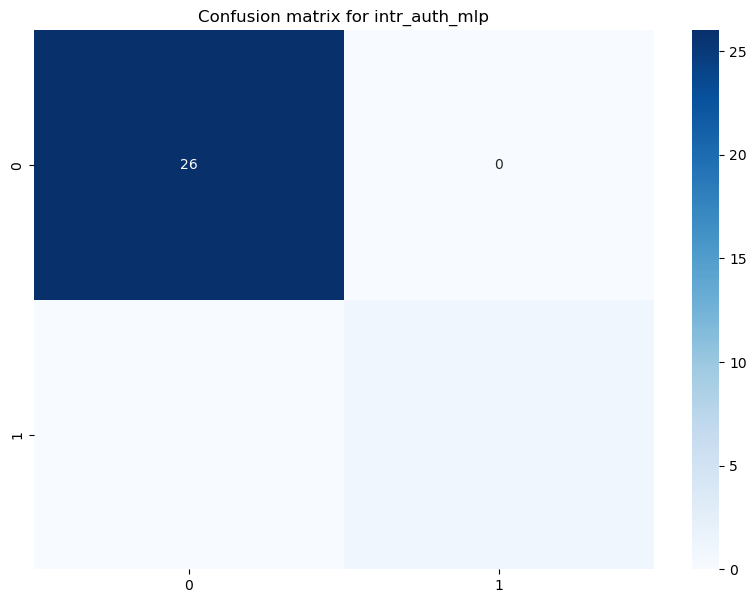

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

for name, result in results.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion matrix for {name}")
    plt.show()

In [28]:
# Test on unseen data from different dataset:
# (was trained on santos)

unseen_test_path = "../AIT_LD-v2/russellmitchell"        # Works, F1 score about 0.99
#unseen_test_path = "../AIT_LD-v2/harrison"               # Works, F1 score 1.0 
#unseen_test_path = "../AIT_LD-v2/shaw"                   # Works, F1 score about 0.99
#unseen_test_path = "../AIT_LD-v2/wheeler"                # Works, F1 score 1.0
#unseen_test_path = "../AIT_LD-v2/wardbeck"               # Works, F1 score about 0.99
#unseen_test_path = "../AIT_LD-v2/fox"                    # Works, F1 score about 0.99
#unseen_test_path = "../AIT_LD-v2/wilson"                 # Works, F1 score about 0.99

In [30]:
df_unseen = load_data_robust(unseen_test_path + path_log_file)

#df_unseen['timestamp'] = df_unseen[0].str.extract(r'(\w{3}\s\d{2}\s\d{2}:\d{2}:\d{2})')
#df_unseen = df_unseen[["timestamp", 2]]
#df_unseen.columns = ["timestamp", "message"]
#df_unseen["message"] = df_unseen["message"].str.replace(r'(\w{3}\s\d{2}\s\d{2}:\d{2}:\d{2})', '', regex=True)

df_unseen

,timestamp,message
0,Jan 23 06:25:05,CRON[22883]: pam_unix(cron:session): session c...
1,Jan 23 06:39:01,CRON[23064]: pam_unix(cron:session): session o...
2,Jan 23 06:39:01,CRON[23064]: pam_unix(cron:session): session c...
3,Jan 23 06:47:01,CRON[23137]: pam_unix(cron:session): session o...
4,Jan 23 06:47:02,CRON[23137]: pam_unix(cron:session): session c...
...,...,...
267,Jan 24 23:09:01,CRON[31372]: pam_unix(cron:session): session c...
268,Jan 24 23:17:01,CRON[31443]: pam_unix(cron:session): session o...
269,Jan 24 23:17:01,CRON[31443]: pam_unix(cron:session): session c...
270,Jan 24 23:39:01,CRON[31519]: pam_unix(cron:session): session o...


In [31]:
unseen_features = extract_features(df_unseen)

unseen_features

,prcs_sudo,prcs_su,prcs_sshd,prcs_cron,dir_root,dir_shadow,dir_passwd,sess_open,sess_close,sess_new,user_switch
0,False,False,False,True,False,False,False,False,True,False,False
1,False,False,False,True,False,False,False,True,False,False,False
2,False,False,False,True,False,False,False,False,True,False,False
3,False,False,False,True,False,False,False,True,False,False,False
4,False,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
267,False,False,False,True,False,False,False,False,True,False,False
268,False,False,False,True,False,False,False,True,False,False,False
269,False,False,False,True,False,False,False,False,True,False,False
270,False,False,False,True,False,False,False,True,False,False,False


In [32]:
# Classify with each model:

def classify_unseen_data():
    for name, model in models.items():
        print(f"Model: {name}")
        unseen_predictions = model.predict(unseen_features)
        print(unseen_predictions)

    return unseen_predictions

unseen_predictions = classify_unseen_data()

Model: intr_auth_randomforest
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Model: intr_auth_gradientboost
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 

In [33]:
# Compare to true labels

df_unseen_true_labels = load_true_labels(unseen_test_path + path_true_labels)

#New dataframe same size as df_unseen
df_binary_true_labels = pd.DataFrame(0, index=range(len(df_unseen)), columns=["true_type"])
for index, row in df_unseen_true_labels.iterrows():
    df_binary_true_labels.loc[row["line"] -1] = 1


print(df_binary_true_labels.iloc[143:153])
print(df_unseen.iloc[143:153])


     true_type
143          0
144          1
145          1
146          1
147          1
148          1
149          1
150          1
151          1
152          0
           timestamp                                            message
143  Jan 24 04:17:01  CRON[27933]: pam_unix(cron:session): session c...
144  Jan 24 04:37:40     su[27950]: Successful su for jhall by www-data
145  Jan 24 04:37:40             su[27950]: + /dev/pts/1 www-data:jhall
146  Jan 24 04:37:40  su[27950]: pam_unix(su:session): session opene...
147  Jan 24 04:37:40  systemd-logind[957]: New session c1 of user jh...
148  Jan 24 04:37:58  sudo:    jhall : TTY=pts/1 ; PWD=/var/www/intr...
149  Jan 24 04:38:06  sudo:    jhall : TTY=pts/1 ; PWD=/var/www/intr...
150  Jan 24 04:38:06  sudo: pam_unix(sudo:session): session opened f...
151  Jan 24 04:38:06  sudo: pam_unix(sudo:session): session closed f...
152  Jan 24 04:39:01  CRON[27969]: pam_unix(cron:session): session o...


In [34]:
for name, model in models.items():
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(df_binary_true_labels, unseen_predictions)}")
    print(f"Precision: {precision_score(df_binary_true_labels, unseen_predictions, average='weighted')}")
    print(f"Recall: {recall_score(df_binary_true_labels, unseen_predictions, average='weighted')}")
    print(f"F1: {f1_score(df_binary_true_labels, unseen_predictions, average='weighted')}")

    print("-----------------------")


Model: intr_auth_randomforest
Accuracy: 0.9889705882352942
Precision: 0.9919786096256684
Recall: 0.9889705882352942
F1: 0.989809818664308
-----------------------
Model: intr_auth_gradientboost
Accuracy: 0.9889705882352942
Precision: 0.9919786096256684
Recall: 0.9889705882352942
F1: 0.989809818664308
-----------------------
Model: intr_auth_svc
Accuracy: 0.9889705882352942
Precision: 0.9919786096256684
Recall: 0.9889705882352942
F1: 0.989809818664308
-----------------------
Model: intr_auth_mlp
Accuracy: 0.9889705882352942
Precision: 0.9919786096256684
Recall: 0.9889705882352942
F1: 0.989809818664308
-----------------------


In [35]:
# Get all the original log lines that were classified as attack related
df_unseen["predicted"] = unseen_predictions

df_attack_related_predictions = df_unseen[df_unseen["predicted"] == 1]

df_attack_related_predictions

,timestamp,message,predicted
66,Jan 23 16:23:04,systemd-logind[957]: Removed session 111.,1
69,Jan 23 16:30:47,systemd: pam_unix(systemd-user:session): sessi...,1
70,Jan 23 16:30:47,systemd-logind[957]: New session 271 of user j...,1
144,Jan 24 04:37:40,su[27950]: Successful su for jhall by www-data,1
145,Jan 24 04:37:40,su[27950]: + /dev/pts/1 www-data:jhall,1
146,Jan 24 04:37:40,su[27950]: pam_unix(su:session): session opene...,1
147,Jan 24 04:37:40,systemd-logind[957]: New session c1 of user jh...,1
148,Jan 24 04:37:58,sudo: jhall : TTY=pts/1 ; PWD=/var/www/intr...,1
149,Jan 24 04:38:06,sudo: jhall : TTY=pts/1 ; PWD=/var/www/intr...,1
150,Jan 24 04:38:06,sudo: pam_unix(sudo:session): session opened f...,1


In [36]:
df_attack_related_predictions.describe()

,predicted
count,11.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [37]:
# Information this file contributes to the report:
# Compromised user account (and time of gaining root access)
# Which files were accessed
# Which commands were executed in which PWD

# Extract the information from the attack related log lines:

def analyze_security_logs_df(df):
    import re
    """
    Analyzes security log messages from a DataFrame to extract key information about potential security incidents.
    Enhanced to handle multiple log formats and patterns.
   
    Args:
        df (pandas.DataFrame): DataFrame containing log entries with a 'message' column
   
    Returns:
        dict: Dictionary containing analyzed security information
    """
    results = {
        "compromised_users": [],  
        "root_access_events": [], 
        "accessed_files": [],     
        "executed_commands": []
    }
   
    for _, row in df.iterrows():
        message = row['message']
        timestamp = row.get('timestamp', 'Unknown time')
       
        # Check for user compromise via su
        if 'Successful su for' in message:
            user = re.search(r'su for (\w+)', message)
            source = re.search(r'by (\w+[-]?\w+)', message)
            if user and source:
                results["compromised_users"].append({
                    'timestamp': timestamp,
                    'user': user.group(1),
                    'source_user': source.group(1),
                    'method': 'su'
                })
       
        # Check for sudo commands
        if 'sudo:' in message:
            # Extract user and command info
            sudo_match = re.search(r'sudo:\s+(\w+)\s*:.*USER=(\w+)\s*;\s*COMMAND=(.+?)(?:$|\s*;)', message)
            if sudo_match:
                user, target_user, command = sudo_match.groups()
               
                # Add root access event
                if target_user == 'root':
                    results["root_access_events"].append({
                        'timestamp': timestamp,
                        'user': user,
                        'method': 'sudo'
                    })
               
                # Extract PWD if present
                pwd_match = re.search(r'PWD=([^;]+)', message)
                pwd = None
                if pwd_match:
                    pwd = pwd_match.group(1)
                    
                # Add command execution
                results["executed_commands"].append({
                    'timestamp': timestamp,
                    'user': user,
                    'command': command.strip(),
                    'working_directory' : pwd,
                    'target_user': target_user
                })
               
                # Check for specific file access commands
                if '/bin/cat' in command:
                    file_match = re.search(r'/bin/cat\s+([^\s;]+)', command)
                    if file_match:
                        file_access = {
                            'timestamp': timestamp,
                            'file_path': file_match.group(1),
                            'user': user,
                            'command': 'cat',
                            'access_type': 'read'
                        }
                        results["accessed_files"].append(file_access)
                elif '/bin/ls' in command:
                    file_match = re.search(r'/bin/ls\s+(?:-\w+\s+)?([^\s;]+)', command)
                    if file_match:
                        file_access = {
                            'timestamp': timestamp,
                            'file_path': file_match.group(1),
                            'user': user,
                            'command': 'ls',
                            'access_type': 'list'
                        }
                        results["accessed_files"].append(file_access)
       
        # Check for session opens
        if 'session opened for user' in message:
            user_match = re.search(r'session opened for user (\w+)', message)
            if user_match and 'by (uid=0)' in message:
                results["root_access_events"].append({
                    'timestamp': timestamp,
                    'user': user_match.group(1),
                    'method': 'session'
                })
   
    return results

In [38]:
results = analyze_security_logs_df(df_attack_related_predictions)

results

{'compromised_users': [{'timestamp': 'Jan 24 04:37:40',
   'user': 'jhall',
   'source_user': 'www-data',
   'method': 'su'}],
 'root_access_events': [{'timestamp': 'Jan 23 16:30:47',
   'user': 'jhall',
   'method': 'session'},
  {'timestamp': 'Jan 24 04:37:58', 'user': 'jhall', 'method': 'sudo'},
  {'timestamp': 'Jan 24 04:38:06', 'user': 'jhall', 'method': 'sudo'},
  {'timestamp': 'Jan 24 04:38:06', 'user': 'root', 'method': 'session'}],
 'accessed_files': [{'timestamp': 'Jan 24 04:38:06',
   'file_path': '/etc/shadow',
   'user': 'jhall',
   'command': 'cat',
   'access_type': 'read'}],
 'executed_commands': [{'timestamp': 'Jan 24 04:37:58',
   'user': 'jhall',
   'command': 'list',
   'working_directory': '/var/www/intranet.smith.russellmitchell.com/wp-content/uploads/2022/01 ',
   'target_user': 'root'},
  {'timestamp': 'Jan 24 04:38:06',
   'user': 'jhall',
   'command': '/bin/cat /etc/shadow',
   'working_directory': '/var/www/intranet.smith.russellmitchell.com/wp-content/uploa

In [39]:
def format_analysis_results(results):
    """
    Formats the analysis results in a clear, readable way, providing detailed context
    for each type of security-relevant event detected in the logs.
    """
    print("Security Incident Analysis Results")
    print("=================================")
   
    print("\nCompromised User Accounts:")
    print("--------------------------")
    for event in results['compromised_users']:
        print(f"- User: {event['user']} (compromised by {event['source_user']} at {event['timestamp']} via {event['method']})")
   
    print("\nRoot Access Events:")
    print("-----------------")
    for event in results['root_access_events']:
        print(f"- User: {event['user']} gained root access at {event['timestamp']} via {event['method']}")
   
    print("\nExecuted Commands:")
    print("-----------------")
    for cmd in results['executed_commands']:
        print(f"- [{cmd['timestamp']}] {cmd['user']} (as {cmd['target_user']}): {cmd['command']}, PWD: {cmd['working_directory']}")
   
    print("\nAccessed Files:")
    print("--------------")
    # Group file accesses by file path to show access patterns
    file_accesses = {}
    for access in results['accessed_files']:
        file_path = access['file_path']
        if file_path not in file_accesses:
            file_accesses[file_path] = []
        file_accesses[file_path].append(access)
    
    # Print each file's access history
    for file_path, accesses in sorted(file_accesses.items()):
        print(f"\nFile: {file_path}")
        for access in sorted(accesses, key=lambda x: x['timestamp']):
            print(f"  - [{access['timestamp']}] {access['user']} performed {access['access_type']} using {access['command']}")

format_analysis_results(results)

Security Incident Analysis Results

Compromised User Accounts:
--------------------------
- User: jhall (compromised by www-data at Jan 24 04:37:40 via su)

Root Access Events:
-----------------
- User: jhall gained root access at Jan 23 16:30:47 via session
- User: jhall gained root access at Jan 24 04:37:58 via sudo
- User: jhall gained root access at Jan 24 04:38:06 via sudo
- User: root gained root access at Jan 24 04:38:06 via session

Executed Commands:
-----------------
- [Jan 24 04:37:58] jhall (as root): list, PWD: /var/www/intranet.smith.russellmitchell.com/wp-content/uploads/2022/01 
- [Jan 24 04:38:06] jhall (as root): /bin/cat /etc/shadow, PWD: /var/www/intranet.smith.russellmitchell.com/wp-content/uploads/2022/01 

Accessed Files:
--------------

File: /etc/shadow
  - [Jan 24 04:38:06] jhall performed read using cat


In [40]:
import os
from dotenv import load_dotenv
from iris_api_helper import IrisClient

load_dotenv()
iris = IrisClient(api_key=os.getenv("IRIS_API_KEY").__str__())


ModuleNotFoundError: No module named 'iris_api_helper'

In [ ]:
# Test IRIS API stuff without creating a new case each time

# Something that breaks:
#function_that_does_not_exist()

In [ ]:
# Creates a new Case in the IRIS platform:
new_case_id = iris.create_case(
        name="Test Case created from intranet/auth_log",
        description="Test Case created from intranet/auth_log",
    )

print("New case created with case_id: ", new_case_id)

New case created with case_id:  47


In [ ]:
from datetime import datetime

# Loops over analysis results and uploads related Assets, IOCs to IRIS
def upload_incident_analysis_results(results):
    for column in results:
        print("Column: ", column)

        match column:
            # For each compromised user account found, create a new Asset and IOC
            case "compromised_users":
                #print("Compromised User found")
                #print(results[column])
                
                #continue #TODO: Remove this, only during testing to skip already uploaded data
                
                for i in range(len(results[column])):
                    # Add IOC for compromised user account
                    ioc_id = iris.add_ioc_to_case(
                        case_id=new_case_id,
                        value=results[column][i]['user'],
                        ioc_type="account",
                        description="User account found to be compromised at " + results[column][i]['timestamp'] + " (source user: " + results[column][i]['source_user'] + ") " + " by intranet/auth.log"
                    )

                    # Add IOC for source user account
                    source_user_ioc_id = iris.add_ioc_to_case(
                        case_id=new_case_id,
                        value=results[column][i]['source_user'],
                        ioc_type="account",
                        description="Source user account used to compromise " + results[column][i]['user'] + " at " + results[column][i]['timestamp'] + " by intranet/auth.log"
                    )

                    print("IOC IDs: ", ioc_id, source_user_ioc_id)

                    # Add Assets for both, referencing the IOCs
                    iris.add_asset_to_case(
                        case_id=new_case_id,
                        name="Account: " + results[column][i]['user'],
                        asset_type="Account",
                        description="User account found to be compromised at " + results[column][i]['timestamp'] + " (source user: " + results[column][i]['source_user'] + ") " + " by intranet/auth.log",
                        compromise_status = 1,
                        analysis_status = "Started",
                        ioc_links = [ioc_id, source_user_ioc_id]
                    )

                    iris.add_asset_to_case(
                        case_id=new_case_id,
                        name="Source User Account: " + results[column][i]['source_user'],
                        asset_type="Account",
                        description="Source user account used to compromise " + results[column][i]['user'] + " at " + results[column][i]['timestamp'] + " by intranet/auth.log",
                        compromise_status = 1,
                        analysis_status = "Started",
                        ioc_links = [ioc_id, source_user_ioc_id]
                    )

            # For each root access event found, create a new Event (to show up on the timeline)
            case "root_access_events":
                #print("Root Access Events found")
                #print(results[column])

                #continue #TODO: Remove this, only during testing to skip already uploaded data  

                for i in range(len(results[column])):
                    print(results[column][i])

                    ioc_id = iris.check_ioc_exists(new_case_id, results[column][i]['user'], "account")

                    iris.add_event_to_case(
                        case_id=new_case_id,
                        title="Root Access Event: " + results[column][i]['user'],
                        date_time=datetime.strptime(results[column][i]['timestamp'], '%b %d %H:%M:%S'),
                        content="Root access gained by " + results[column][i]['user'] + " at " + results[column][i]['timestamp'] + " via " + results[column][i]['method'],
                        linked_iocs=[ioc_id] if ioc_id is not None else [],
                        # Selected optional parameters worth considering: raw_content, source, linked assets, tags
                    )      
        
            case "accessed_files":
                #print("Accessed Files found")
                #print(results[column])

                #continue #TODO: Remove this, only during testing to skip already uploaded data  

                for i in range(len(results[column])):
                    print(results[column][i])

                    ioc_id = iris.check_ioc_exists(new_case_id, results[column][i]['user'], "account")

                    iris.add_event_to_case(
                        case_id=new_case_id,
                        title="Unauthorized File Access: " + results[column][i]['file_path'],
                        date_time=datetime.strptime(results[column][i]['timestamp'], '%b %d %H:%M:%S'),
                        content="File accessed by " + results[column][i]['user'] + " at " + results[column][i]['timestamp'] + " via " + results[column][i]['command'],
                        linked_iocs=[ioc_id] if ioc_id is not None else [],
                        # Selected optional parameters worth considering: raw_content, source, linked assets, linked iocs, tags
                    )
            
            case "executed_commands":
                print("Executed Commands found")
                print(results[column])
                
                for i in range(len(results[column])):
                    print(results[column][i])

                    ioc_id = iris.check_ioc_exists(new_case_id, results[column][i]['user'], "account")

                    iris.add_event_to_case(
                        case_id=new_case_id,
                        title="Command Executed: " + results[column][i]['command'],
                        date_time=datetime.strptime(results[column][i]['timestamp'], '%b %d %H:%M:%S'),
                        content="Command executed by " + results[column][i]['user'] + " at " + results[column][i]['timestamp'] + " via " + results[column][i]['command'],
                        linked_iocs=[ioc_id] if ioc_id is not None else [],
                        )

            case _: 
                print("--------------- No match ---------------")
                print(results[column])


upload_incident_analysis_results(results)

Column:  compromised_users
IOC IDs:  2 4
Column:  root_access_events
{'timestamp': 'Jan 23 16:30:47', 'user': 'jhall', 'method': 'session'}
{'timestamp': 'Jan 24 04:37:58', 'user': 'jhall', 'method': 'sudo'}
{'timestamp': 'Jan 24 04:38:06', 'user': 'jhall', 'method': 'sudo'}
{'timestamp': 'Jan 24 04:38:06', 'user': 'root', 'method': 'session'}
Column:  accessed_files
{'timestamp': 'Jan 24 04:38:06', 'file_path': '/etc/shadow', 'user': 'jhall', 'command': 'cat', 'access_type': 'read'}
Column:  executed_commands
Executed Commands found
[{'timestamp': 'Jan 24 04:37:58', 'user': 'jhall', 'command': 'list', 'working_directory': '/var/www/intranet.smith.russellmitchell.com/wp-content/uploads/2022/01 ', 'target_user': 'root'}, {'timestamp': 'Jan 24 04:38:06', 'user': 'jhall', 'command': '/bin/cat /etc/shadow', 'working_directory': '/var/www/intranet.smith.russellmitchell.com/wp-content/uploads/2022/01 ', 'target_user': 'root'}]
{'timestamp': 'Jan 24 04:37:58', 'user': 'jhall', 'command': 'lis